In [43]:
from graph import load_graphs, SparseGraph, graph_from_sparse,construct_graphs,feature_names,load_graph_combined
from model import SegmentClassifier
from estimator import Estimator
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.model_selection import train_test_split

In [44]:
cuda=True
if cuda:
    np_to_torch = lambda x, volatile=False: (
        torch.tensor(x.astype(np.float32), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        torch.tensor(x.astype(np.float32), requires_grad=False))

torch_to_np = lambda x: x.cpu().data.numpy()

In [45]:
import torch
from sklearn.model_selection import train_test_split
def merge_graphs(graphs):
    batch_size = len(graphs)
    
    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        return g.X[None], g.Ri[None], g.Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                # torch.from_numpy(batch_X).cuda(),
                # torch.from_numpy(batch_Ri).cuda(),
                # torch.from_numpy(batch_Ro).cuda()
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)
            ]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            # batch_target=torch.from_numpy(batch_y).cuda()
            #print('  data prepared')
            yield batch_inputs, batch_target

In [46]:
import os
folder_path = "/lustrehome/federicacuna/TB_Sept_2023_ml/Data/npz_file_IN/"
lista=os.listdir(folder_path)

In [47]:
graph = [os.path.join(folder_path, file) for file in lista if ".ipynb_checkpoint" not in file  ]

In [5]:
# graphs=load_graphs(lista,folder_path)

In [48]:
def extract_number_from_filename(filename):
    return int(filename.split("_npz")[1].split(".npz")[0])

# Ordina i file basati sul numero compreso tra "_npz" e ".npz" nel loro nome
graph_data_sorted = sorted([os.path.join(folder_path, file) for file in graph], key=extract_number_from_filename)


In [49]:
%%time
data_for_train=[]
# for i in graph_data_sorted:
#     # print(i)
#     data_for_train.extend(load_graph_combined(i))
for i in range(100):#graph_data_sorted:
    print(i)
    i=graph_data_sorted[i]
    data_for_train.extend(load_graph_combined(i))

0
CPU times: user 3min 31s, sys: 325 ms, total: 3min 31s
Wall time: 3min 32s


In [50]:
# graphs=load_graph_combined('test_npz.npz')
graphs=data_for_train

In [51]:
hidden_dim = 64
n_iters = 7
n_samples=len(graphs)
# Training config
batch_size = 1000#32
n_epochs = 100
valid_frac = 0.2
test_frac = 0.2
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(4832, 1376, 672, 6880)

In [52]:
# Partition the dataset
train_graphs, test_graphs = train_test_split(graphs, test_size=n_test)
train_graphs, valid_graphs = train_test_split(train_graphs, test_size=n_valid)

print('Train set size:', len(train_graphs))
print('Valid set size:', len(valid_graphs))
print('Test set size: ', len(test_graphs))

Train set size: 4849
Valid set size: 1376
Test set size:  672


In [53]:
# Prepare the batch generators
train_batcher = batch_generator(train_graphs, n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_graphs, n_samples=n_valid, batch_size=batch_size, train=False)
test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)

In [54]:
model = SegmentClassifier(input_dim=5, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.functional.binary_cross_entropy
estim = Estimator(model, loss_func=loss_func, cuda=True)

2024-04-05 07:38:06.986631 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=138, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=207, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
)
2024-04-05 07:38:06.986843 Parameters: 26817


In [55]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=100,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, verbose=0)

2024-04-05 07:38:09.876875 Epoch 0
2024-04-05 07:38:17.527196   training loss 0.269 time 7.64987s
Epoch_stop: 0
2024-04-05 07:38:19.087516   validate loss 0.217
2024-04-05 07:38:19.087540 Epoch 1
2024-04-05 07:38:25.528036   training loss 0.216 time 6.44047s
Epoch_stop: 1
2024-04-05 07:38:26.847856   validate loss 0.217


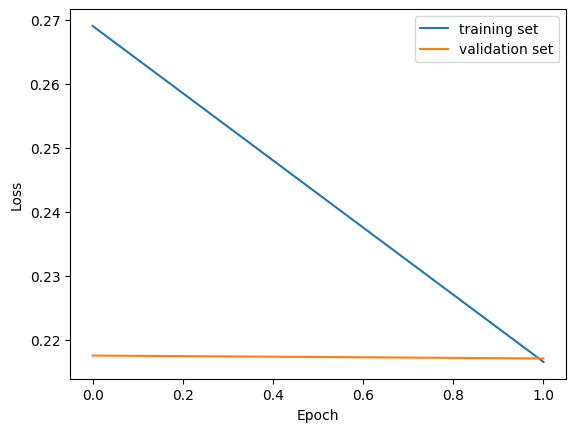

In [56]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

In [61]:
len(test_graphs)

672

In [57]:
test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)
test_outputs = estim.predict(test_batcher,'best_model_IN.pkl', n_test_batches, concat=False)
test_preds = [torch_to_np(o) for o in test_outputs]

# Flatten the predictions and labels
flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
flat_pred = np.concatenate([p.flatten() for p in test_preds])
thresh = 0.8
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

Test set results with threshold of 0.8
Accuracy:  0.4230
Precision: 0.0000
Recall:    0.0000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


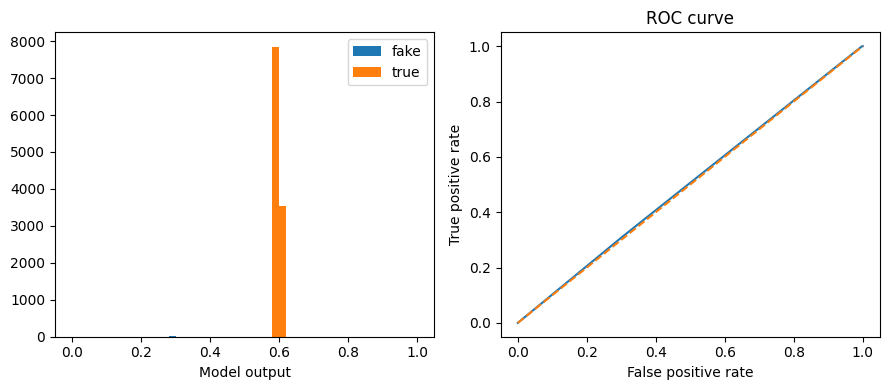

In [49]:
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

In [50]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, ax0 = plt.subplots(figsize=(9,4))
    cmap = plt.get_cmap(cmap)

    ax0.scatter(X[:,2], X[:,1], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='b', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,1], feats_i[j,1]], '-', **seg_args)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(y)
    cbar = plt.colorbar(sm, ax=ax0)
    cbar.set_label('Colorbar Label')  # Set the label for the colorbar
    
    # Adjust axes
    ax0.set_xlabel('zx_hit [mm]')
    ax0.set_ylabel('x_hit ')
    ax0.set_xlim(-100,2000)
    ax0.set_ylim(-20,20)
    plt.tight_layout()
    plt.show()

[0.6179979 0.598146  0.598146  0.598146  0.598146 ]
accuracy 0.400, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


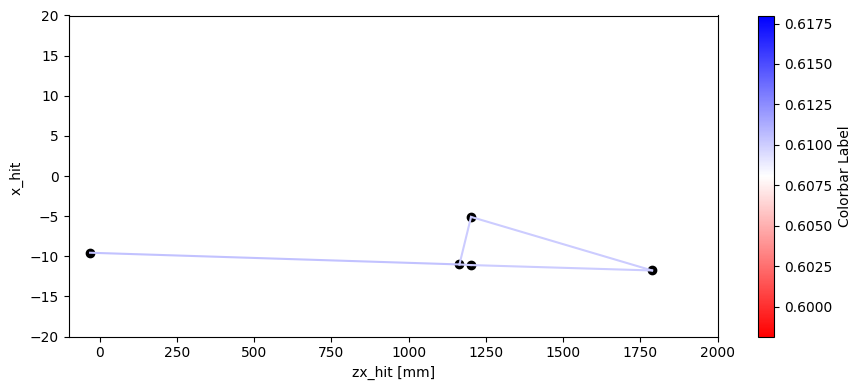

[0.6179979 0.598146  0.598146  0.598146  0.598146 ]
accuracy 0.400, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


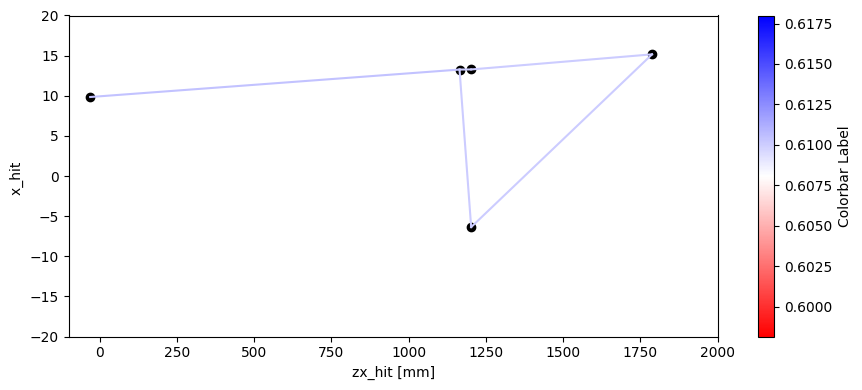

[0.6179979 0.598146  0.598146 ]
accuracy 0.000, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


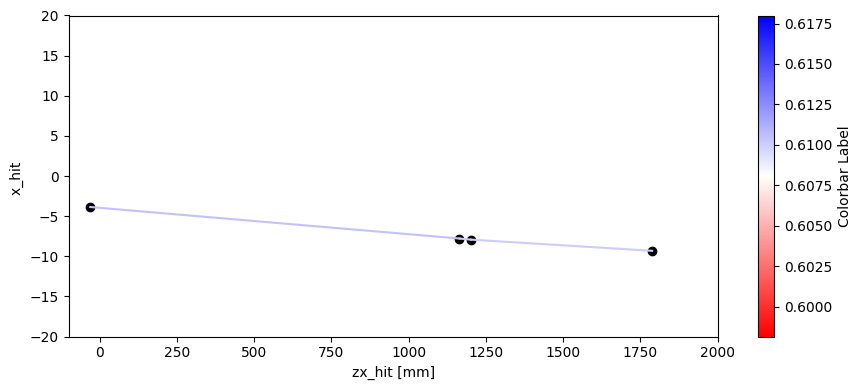

[0.6179979 0.598146  0.598146  0.598146  0.598146  0.598146  0.598146 ]
accuracy 0.286, precision 0.000, recall 0.000


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


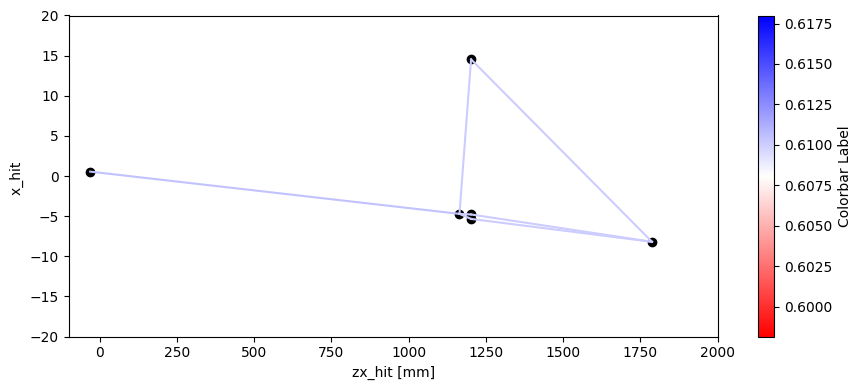

In [51]:
for i in range(4):
    g = (test_graphs[i])
    pred = test_preds[i].squeeze(0)
    print(pred)
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(g.y, pred>thresh),
        sklearn.metrics.precision_score(g.y, pred>thresh),
        sklearn.metrics.recall_score(g.y, pred>thresh)))
    draw_sample(g.X, g.Ri, g.Ro, pred, alpha_labels=False);